SVR R^2: 0.724245
SVR MSE: 0.126723


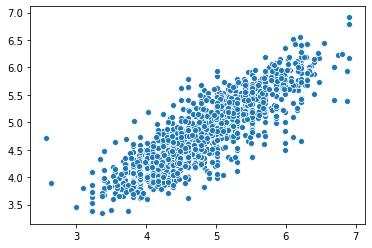

In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns
import sklearn.metrics as sm

base_path = '/home/maj/data/insideairbnb/processed/'
train = pd.read_csv(base_path + 'train.csv', low_memory=False)
validate = pd.read_csv(base_path + 'validate.csv', low_memory=False)
test = pd.read_csv(base_path + 'test.csv', low_memory=False)
train_validate = pd.concat([train, validate], keys=['train', 'val'])
drop_columns = ['price_log', 'host_has_profile_pic', 'is_business_travel_ready', 'distance_to_san_diego_zoo']
X_train = train.drop(drop_columns, axis=1).to_numpy()
X_validate = validate.drop(drop_columns, axis=1).to_numpy()
X_train_validate = train_validate.drop(drop_columns, axis=1).to_numpy()
X_test = test.drop(drop_columns, axis=1).to_numpy()
# SVR with {'C': 4, 'epsilon': 0.05, 'gamma': 0.0078125} (= 2**-7)
m_svr = SVR(kernel='rbf', C=4, epsilon=0.05, gamma=2**-7).fit(X_train_validate, train_validate.price_log.to_numpy())
print("SVR R^2: %f" % m_svr.score(X_test, test.price_log.to_numpy()))
print("SVR MSE: %f" % sm.mean_squared_error(test.price_log.to_numpy(), m_svr.predict(X_test).flatten()))
ax = sns.scatterplot(test.price_log.to_numpy(), m_svr.predict(X_test).flatten())

KNNR R^2: 0.649397
KNNR MSE: 0.161120


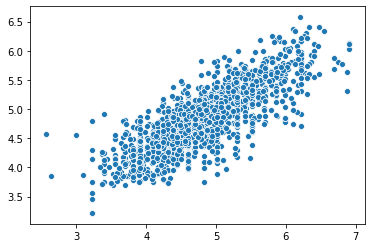

In [2]:
# KNNR with {'n_neighbors': 7, 'p': 1}
m_knnr = KNeighborsRegressor(algorithm='brute', n_neighbors=7, p=1).fit(X_train_validate, train_validate.price_log.to_numpy())
print("KNNR R^2: %f" % m_knnr.score(X_test, test.price_log.to_numpy()))
print("KNNR MSE: %f" % sm.mean_squared_error(test.price_log.to_numpy(), m_knnr.predict(X_test).flatten()))
ax = sns.scatterplot(test.price_log.to_numpy(), m_knnr.predict(X_test).flatten())            

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  296       
_________________________________________________________________
dense (Dense)                multiple                  9600      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  5

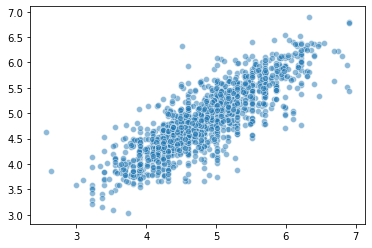

In [3]:
# DNN with {'neurons': 64}
neurons = 128
m_dnn = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
m_dnn.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) # also sgd, keras.optimizers.RMSprop
m_dnn.fit(X_train, train.price_log.to_numpy(), epochs=900, batch_size=512,
          validation_data=(X_validate, validate.price_log.to_numpy()), verbose=0)
print(m_dnn.summary())
print("\n\nDNN MSE: %f" % m_dnn.evaluate(X_test, test.price_log.to_numpy(), verbose=0)[0])
ax = sns.scatterplot(x=test.price_log.to_numpy(), y=m_dnn.predict(X_test).flatten(), alpha=0.5)